In [31]:
# You can set your own libraries search path by adding M2AIA_PATH to your system environment variables
#  - For installed versions of M2aia point to the /path/to/m2aia/installation/bin directory
#  - For compiled versions of M2aia point to the /path/to/m2aia/build/MITK-build/lib directory

# import os
# os.environ["M2AIA_PATH"] = "/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib/"

In [32]:
# download the example files if required
# for all examples continuos profile data are used
from download_helper import DownloadMTBLS2639
# if wanted, you can replace the file_names list with data on your disk
# e.g. filenames = ["my/files/location/data.imzML", "..."]
file_names = DownloadMTBLS2639(selection=[3]) # only slice 3 is selected, you choose fom [0,1,2,3]

In [33]:
import pathlib
import seaborn
import umap
import torch

import numpy as np
import m2aia as m2
import matplotlib.pyplot as plt 

from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam

from sklearn import cluster
from scipy import signal
from torchvision import transforms

from SimCLR.code.models import CLR, ContrastiveLoss
from Example_V_Helpers import gaussian_noise, AugmentedDataset


In [34]:
# Clustering Parameters
n_clusters = 10
n_neighbors = 10

# Network Parameters
# model input dimension for height and width of the input images
# ion images are center cropped to the max dimension of the image and subsequently resized to a size of 124x124
# see augmentation functions
target_input_size = 124 
epochs = 1000
batch_size = 64

In [35]:
#===================================
# 1.1 Load image handles
#===================================
image_handles = []
for f in file_names:
    I = m2.ImzMLReader(f,
                       pooling=m2.m2PoolingMaximum,
                       normalization=m2.m2NormalizationTIC)
    image_handles.append(I)
    print(I.GetShape())
max_dim = np.max(I.GetShape())

[4398.574] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 224x169x1
	[num spectra]: 28278
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
	[normalization]: TIC
[224 169   1]


In [36]:
#===================================
# 1.1 Pick peaks (mean spectrum)
#===================================
mean = I.GetMeanSpectrum()
min_indices = signal.argrelmin(mean,order=50)[0]
xs = I.GetXAxis()
peaks = signal.find_peaks(mean, height=np.median(mean)*3.5)
centroids = xs[peaks[0]].tolist()
print("Number of centroids", len(centroids))

Number of centroids 148


In [37]:
#===================================
# Initialize the ion image Dataset
#===================================
# Transformations functions using torchvision's transforms
# are used to create a uniform output of the ion image generator (dataset)

# 1. - 99th Quantile normalization 
#    - clipping values between 0 and 1 
#    - conversion to a torch tensor
# 2. Center cropping
# 3. Resizing

transform_rm_outlies_center_crop_resize = transforms.Compose([
                                          transforms.Lambda(lambda x : torch.Tensor(np.clip(x / np.quantile(x,0.999),0,1))),
                                          transforms.CenterCrop(max_dim),
                                          transforms.Resize(target_input_size)])

dataset = m2.IonImageDataset(image_handles, 
                            centroids=centroids, 
                            tolerance=75, 
                            tolerance_type='ppm', 
                            buffer_type='memory', 
                            transforms=transform_rm_outlies_center_crop_resize)

# print(dataset[0].shape)
# the output shape is now a tensor of shape [1,124,124]

In [43]:
#===================================
# 1.3 Initialize the augmented ion image 
# Dataset which is used during training
#===================================
# Using: from Example_V_Helpers import gaussian_noise, AugmentedDataset

# Dataset returns two augmentations of the same ion image which follow the original publications
# Hu,H. et al. (2022) Self-supervised clustering of mass spectrometry imaging data using contrastive learning. Chem. Sci., 13, 90–98.
# 1. Conversion to a tensor of type float32
# 2. Apply gaussian blur
# 3. Color jitter (in this case only grayscale jitter, but to be conform wit the original work we use the same term here)
# 4. Add gaussian noise

blur_kernel_size = 9
augmentations = transforms.Compose([transforms.GaussianBlur(blur_kernel_size, sigma=(0.01, 0.75)), 
                                    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2), 
                                    transforms.Lambda(gaussian_noise)])

# the Augmentation dataset now queries a sample from the dataset
# and returns two augmented versions of the ion-image
aug_dataset = AugmentedDataset(dataset, augmentations)

# print(aug_dataset[0][0].shape, aug_dataset[0][1].shape)
# the output shape is still two tensors of shape [1,124,124]

In [44]:
#===================================
# 2 Initializing the SimCLR model
#===================================
m = CLR()
m = m.cuda()

# for reproducibility load/save the model
models_root = pathlib.Path("models")
models_root.mkdir(exist_ok=True)
model_path = models_root.joinpath("Example_V_0.model")

if model_path.exists():
    state_dict = torch.load(str(model_path))
    m.load_state_dict(state_dict)
else:
    torch.save(m.state_dict(), str(model_path))
    

Loaded pretrained weights for efficientnet-b0


In [45]:
#===================================
# 2.1 Predict embeddings of the images
# using the unmodified efficient net model
#===================================

m.eval()
A = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if A is None:
        A = embedding
    else:
        A = np.concatenate([A, embedding])

/tmp/ipykernel_191265/3646328705.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: F

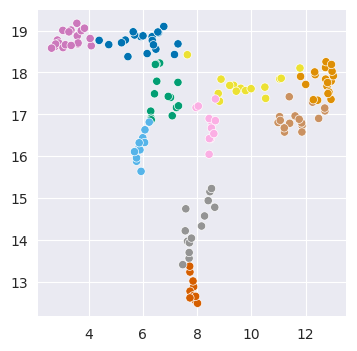

In [46]:
#===================================
# 2.2 Cluster the results using SpectralCustering
#===================================
predictor =  cluster.SpectralClustering(random_state=42,
                                   n_clusters=n_clusters, 
                                   n_neighbors = n_neighbors,
                                   affinity = 'nearest_neighbors', 
                                   assign_labels='discretize')
clusteredA = predictor.fit_predict(A)

#===================================
# 2.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedA = transformer.fit_transform(A)

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
fig = seaborn.scatterplot(x=transformedA[:,0], y=transformedA[:,1],hue=clusteredA, legend=False, palette="colorblind")


# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

In [47]:
#===================================
# 3 Load trained model parameters
#===================================
models_root = pathlib.Path("models")
models_root.mkdir(exist_ok=True)
model_path = models_root.joinpath("Example_V_1.model")

if model_path.exists():
    state_dict = torch.load(str(model_path))
    m.load_state_dict(state_dict)
else:
#===================================
# 3 Start finetuning and save model
#===================================

    loss = ContrastiveLoss(batch_size)
    loss = loss.cuda()

    optim = Adam(m.parameters())
    scheduler = CosineAnnealingLR(optim, epochs)

    # the batch generator if pytorch is used in combination with the augmented dataset
    # to produce batches for the training procedure
    dataloader = DataLoader(aug_dataset,
                            batch_size = batch_size, 
                            sampler = SubsetRandomSampler(list(range(len(aug_dataset)))),
                            pin_memory = True,
                            drop_last = True)

    m.train()
    ## main fit steps
    total_losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, [X, Y] in enumerate(dataloader):
            X = X.cuda(non_blocking=True)
            Y = Y.cuda(non_blocking=True)
            _, proj_X = m(X)
            _, proj_Y = m(Y)
            loss_value = loss(proj_X, proj_Y)
            epoch_losses.append(loss_value)
            
            # backward
            optim.zero_grad()
            loss_value.backward()
            optim.step()

        # update lr
        scheduler.step()
        losses_np = torch.tensor(epoch_losses).cpu().numpy()
        print('epoch {} loss: {}'.format(epoch, np.mean(losses_np)) , end='\r')
    
    torch.save(m.state_dict(), str(model_path))

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [48]:
#===================================
# 3.1 Predict embeddings of the images
# using the now finetuned model
#===================================

m.eval()
hatA = None
for ionImage in dataset:
    # Dataset returns item of form [C,H,W]
    # Network requires items of form [N,C,H,W]
    _, embedding = m(torch.tensor(ionImage[None,...]).cuda())
    embedding = embedding.cpu().detach().numpy()
    if hatA is None:
        hatA = embedding
    else:
        hatA = np.concatenate([hatA, embedding])

/tmp/ipykernel_191265/344714076.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, embedding = m(torch.tensor(ionImage[None,...]).cuda())


/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: F

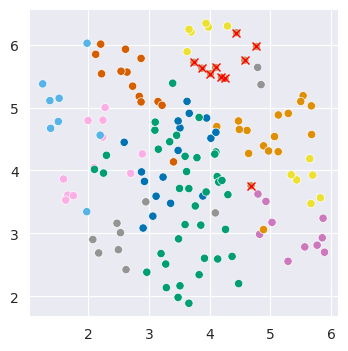

In [49]:
#===================================
# 3.2 Cluster the results using SpectralCustering
#===================================
predictor = cluster.SpectralClustering(random_state=42,
                                n_clusters=n_clusters, 
                                n_neighbors = n_neighbors,
                                affinity = 'nearest_neighbors', 
                                assign_labels='discretize')
clusteredHatA = predictor.fit_predict(hatA)

#===================================
# 3.3 Use UMAP embeddings
#===================================
transformer = umap.UMAP(random_state=65)
transformedHatA = transformer.fit_transform(hatA)

# highlighted cluster
targetCluster = 5

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
import pandas as pd
# data = pd.DataFrame(np.concatenate([r, c[...,None]],axis=1))

fig = seaborn.scatterplot(x=transformedHatA[:,0], y=transformedHatA[:,1], hue=clusteredHatA ,legend=False, palette='colorblind')
plt.plot(transformedHatA[:,0][clusteredHatA == targetCluster], transformedHatA[:,1][clusteredHatA == targetCluster], 'rx')


# plt.title("B", {'fontweight' : 'bold', 'verticalalignment': 'baseline', 'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS83_post.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS83_post.png", dpi=350)

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


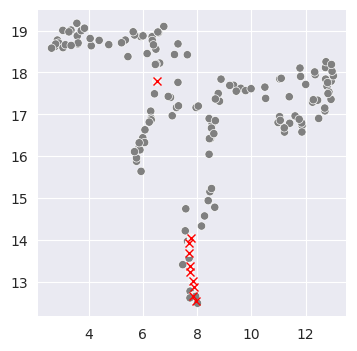

In [50]:
#===================================
# 2.3 Use UMAP embeddings
#===================================
# r_0 = t.transform(dt_0)
# c_0 = km_0.fit_predict(r_0)

seaborn.set_style('darkgrid')
plt.figure(figsize=(4,4))
d = seaborn.color_palette("light:grey", as_cmap=True)
markedClusters = clusteredHatA
markedClusters[markedClusters!=targetCluster] = 250
fig = seaborn.scatterplot(x=transformedA[:,0], y=transformedA[:,1], hue=markedClusters, legend=False, palette=d)
plt.plot(transformedA[:,0][clusteredHatA == targetCluster], transformedA[:,1][clusteredHatA == targetCluster], 'rx')
# plt.plot(r_0[:,0][c == 2], r_0[:,1][c == 2], 'or')
# plt.title("A", {'fontweight' : 'bold',
#  'verticalalignment': 'baseline',
#  'horizontalalignment': 'left'})
# plt.savefig(f"{target_path}/FigS81_pre.eps", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.tif", dpi=350)
# plt.savefig(f"{target_path}/FigS81_pre.png", dpi=350)

/home/jtfc/HS/M2aia/Sources/pym2aia-examples/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


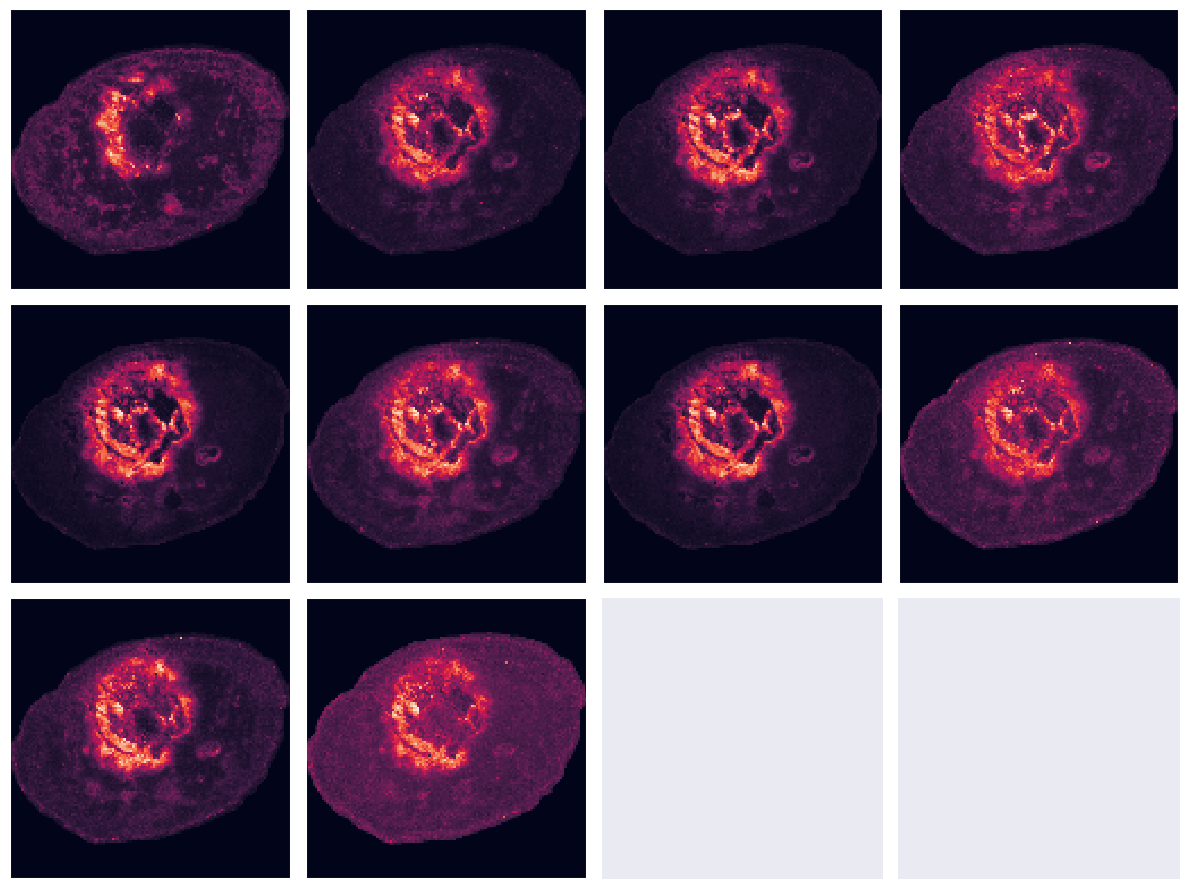

In [51]:
import seaborn_image as isns

ids = np.argwhere(clusteredHatA == targetCluster).flatten().tolist()
images=[]
for id in ids:
    images.append(dataset[id][0])

isns.ImageGrid(images, cbar=False, col_wrap=4)
# plt.savefig(f"{target_path}/FigS8Cluster.png", dpi=350)